In [ ]:
import os
# Root directory of the project
ROOT_DIR = os.path.abspath('/kaggle/input/rsna-pneumonia-detection-challenge')

# Directory to save logs and trained model
MODEL_DIR = os.path.abspath('/kaggle/output/kaggle/working')
LOG_DIR = os.path.join(MODEL_DIR, 'logs')
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
os.chdir(MODEL_DIR)

In [42]:
!pwd

/kaggle/output/kaggle/working/stage_2_test_images


In [43]:
import pandas as pd
stage_2_detailed_class_info = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")
stage_2_sample_submission = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv")
stage_2_train_labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [ ]:
# variables holding the directory paths to test and train images set
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

In [44]:
import matplotlib.pyplot as plt
import pydicom

testImgPath = os.path.join(ROOT_DIR, 'stage_2_test_images/00330f7f-d114-4eb2-9c6e-558eeb3084a1.dcm')
dataset = pydicom.dcmread(testImgPath)
print(dataset)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29914.1517874494.562398
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00330f7f-d114-4eb2-9c6e-558eeb3084a1'
(0010, 0020) Patient ID                          LO: '00330f7f-d114-4eb2-9c6e-558eeb3084a1'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

Image size.......: 1024 x 1024, 104022 bytes
Pixel spacing....: [0.168, 0.168]
Slice location...: (missing)


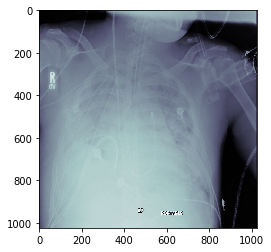

In [45]:
if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

30227 class infos loaded
26684 patient cases


,patientId,class
7489,5777035e-6415-45c0-a12c-b85f01256574,Lung Opacity
23176,d0d7dab6-1938-4859-beca-987458d20699,Lung Opacity
3622,3993a64f-ab45-4594-abe9-2807e19a1d71,Lung Opacity


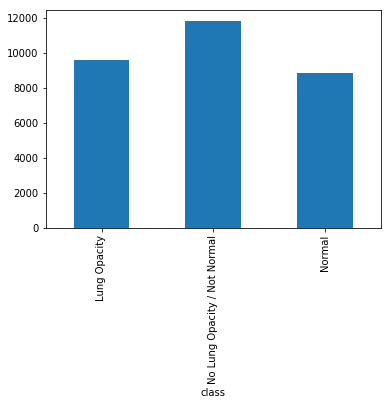

In [46]:
#Divide test images into clear groups and then perform bounding box prediction on the suspicious images
print(stage_2_detailed_class_info.shape[0], 'class infos loaded')
print(stage_2_detailed_class_info['patientId'].value_counts().shape[0], 'patient cases')
stage_2_detailed_class_info.groupby('class').size().plot.bar()
stage_2_detailed_class_info.sample(3)

In [47]:
#concatenate the two datasets (viz. 'stage_2_detailed_class_info' & 'stage_2_train_labels') to get class and target information on each region
comb_bbox_df = pd.concat([stage_2_train_labels, stage_2_detailed_class_info.drop('patientId',1)], 1)
box_df = comb_bbox_df.groupby('patientId').size().reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

30227 combined cases


,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [48]:
#Examine few images having boxes and labels
from glob import glob
image_df = pd.DataFrame({'path': glob(os.path.join(train_dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
image_bbox_df = pd.merge(comb_box_df, image_df, on='patientId', how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...


In [49]:
#Visualize sample dataset covering different pneumonia cases and number of bounding boxes corresponding to the same
sample_df = image_bbox_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,be39655e-b535-44d8-9150-306a7e40fa32,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
1,85d9875a-9fac-4422-a92b-08a593461a51,NaN,NaN,NaN,NaN,0,Normal,1,/kaggle/input/rsna-pneumonia-detection-challen...
2,9911bf13-bce6-4b33-b866-1944aca8fab0,543.0,553.0,293.0,212.0,1,Lung Opacity,1,/kaggle/input/rsna-pneumonia-detection-challen...
3,25465a29-78c4-44cf-984d-b3b9477f2de2,207.0,445.0,143.0,314.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
4,25465a29-78c4-44cf-984d-b3b9477f2de2,580.0,479.0,179.0,310.0,1,Lung Opacity,2,/kaggle/input/rsna-pneumonia-detection-challen...
5,2e4b20f7-69c4-4680-9c8b-6984c195b1cf,578.0,217.0,107.0,183.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
6,2e4b20f7-69c4-4680-9c8b-6984c195b1cf,675.0,470.0,168.0,172.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
7,2e4b20f7-69c4-4680-9c8b-6984c195b1cf,176.0,595.0,124.0,117.0,1,Lung Opacity,3,/kaggle/input/rsna-pneumonia-detection-challen...
8,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,633.0,128.0,90.0,195.0,1,Lung Opacity,4,/kaggle/input/rsna-pneumonia-detection-challen...
9,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,342.0,157.0,148.0,113.0,1,Lung Opacity,4,/kaggle/input/rsna-pneumonia-detection-challen...


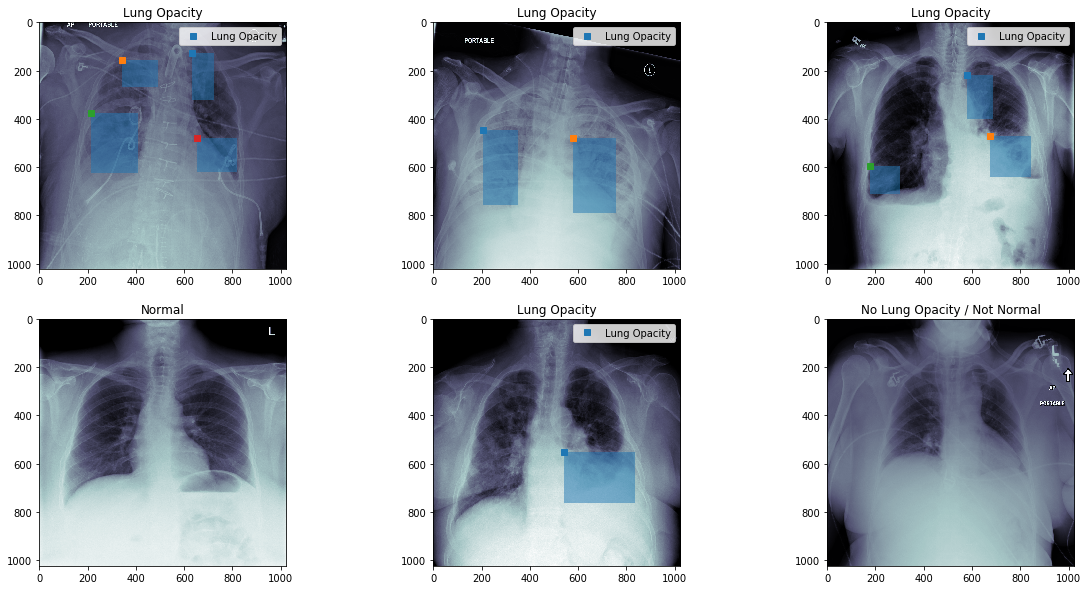

In [50]:
#Visualize the position and bounding box location corresponding to the different pneumonia cases
%matplotlib inline
from matplotlib.patches import Rectangle
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

In [52]:
#Load requirements from the Keras library
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

In [53]:
#dimensions of our images
img_width, img_height = 1024, 1024

#epochs = number of passes of through training data
#batch_size = number of images processed at same time
train_samples = 65
validation_samples = 10
epochs = 20
batch_size = 5

#build the Inception V3 network, use pre-trained weights from ImageNet
#remove top fully connected layers by include_top = False
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [54]:
#Build a classifier model to put on top of the convolutional model
#This consists of a global average pooling layer and a fully connected layer with 256 nodes
#Then apply dropout and sigmoid activation

model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:],data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model=Model(inputs=base_model.input, outputs=model_top(base_model.output))

#Compile model using Adam optimizer with common values and binary cross entropy loss
#Use low learning rate (lr) for transfer learning
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
#Specify augmentation options, which include transformations and other variations to the image, 
#which can help preempt overfitting or “memorization” of training data, and have shown to increase accuracy 
#and generalization of CNNs

train_datagen = ImageDataGenerator(\
                                  rescale=1./255, #Rescale pixel values 0-1 to aid CNN processing
                                  shear_range=0.2, #0-1 range for shearing
                                  zoom_range=0.2, #0-1 range for zoom
                                  rotation_range=20, #0-180 range, degress of rotation
                                  width_shift_range=0.2, #0-1 range horizontal translation
                                  height_shift_range=0.2, #0-1 range vertical translation
                                  horizontal_flip=True,
                                  fill_mode='nearest') #set True or False

val_datagen = ImageDataGenerator(\
                                rescale=1./255) #Rescale pixel values 0-1 to aid CNN processing

In [ ]:
#To check if the dcm files exist in the directory as appearing on the tree structure
from keras.preprocessing.image import array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(os.path.join(ROOT_DIR, 'stage_2_test_images/00330f7f-d114-4eb2-9c6e-558eeb3084a1.dcm'))  # this is a DICOM image
#img = load_img('../input/rsna-pneumonia-detection-challenge/stage_2_train_images/000924cf-0f8d-42bd-9158-1af53881a557.dcm')
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'output' directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/kaggle/output/kaggle/working', save_prefix='pneu', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [ ]:
#os.chdir('/kaggle/output/kaggle/working')
#WRK_TRAIN_DIR = os.path.join('/kaggle/output/kaggle/working', 'stage_2_train_images')
WRK_TEST_DIR = os.path.join('/kaggle/output/kaggle/working', 'stage_2_test_images')
if not os.path.exists(WRK_TEST_DIR):
    os.makedirs(WRK_TEST_DIR)
os.chdir(WRK_TEST_DIR)

In [57]:
os.chdir(WRK_TRAIN_DIR)
!pwd
!ls -l

/kaggle/output/kaggle/working/stage_2_train_images
total 2525692
-rw-r--r-- 1 root root 425078 Feb 12 19:39 0004cfab-14fd-4e49-80ba-63a80b6bddd6.png
-rw-r--r-- 1 root root 384434 Feb 12 19:36 000fe35a-2649-43d4-b027-e67796d412e0.png
-rw-r--r-- 1 root root 438721 Feb 12 19:37 0022995a-45eb-4cfa-9a59-cd15f5196c64.png
-rw-r--r-- 1 root root 379477 Feb 12 19:39 00436515-870c-4b36-a041-de91049b9ab4.png
-rw-r--r-- 1 root root 381811 Feb 12 19:38 0053ee32-1e03-4dc2-a103-f46ad0448787.png
-rw-r--r-- 1 root root 389943 Feb 12 19:38 005f5517-ab76-4b0d-8a26-f808d97171c4.png
-rw-r--r-- 1 root root 463049 Feb 12 19:36 006cec2e-6ce2-4549-bffa-eadfcd1e9970.png
-rw-r--r-- 1 root root 378853 Feb 12 19:35 00704310-78a8-4b38-8475-49f4573b2dbb.png
-rw-r--r-- 1 root root 436978 Feb 12 19:35 0088be53-27f2-4c30-882b-a73a3a5c8c71.png
-rw-r--r-- 1 root root 191503 Feb 12 19:37 00aecb01-a116-45a2-956c-08d2fa55433f.png
-rw-r--r-- 1 root root 444843 Feb 12 19:37 00f08de1-517e-4652-a04f-d1dc9ee48593.png
-rw-r--r-- 

-rw-r--r-- 1 root root 378062 Feb 12 19:37 9cb05dbd-0a9b-410e-aa72-9a93594c86d0.png
-rw-r--r-- 1 root root 347178 Feb 12 19:37 9cb1987f-476b-43a1-aaa1-9fa529333262.png
-rw-r--r-- 1 root root 364918 Feb 12 19:35 9cbd5b98-7ccd-4660-aee1-7467f20a76c9.png
-rw-r--r-- 1 root root 452647 Feb 12 19:37 9cc54cd5-c46f-47a1-aeb5-2e24f1575255.png
-rw-r--r-- 1 root root 358275 Feb 12 19:38 9cc6707b-0793-492b-b59a-ededa08fb144.png
-rw-r--r-- 1 root root 416528 Feb 12 19:36 9cd4233f-b8c0-4c4f-82f2-5b7cfe3255d1.png
-rw-r--r-- 1 root root 337714 Feb 12 19:37 9cdad022-25d5-4596-b709-d022f475c26c.png
-rw-r--r-- 1 root root 427888 Feb 12 19:39 9cdd71e2-ca33-4fe6-90f3-153f8f76e5dc.png
-rw-r--r-- 1 root root 411698 Feb 12 19:37 9ce1cb14-c08c-438d-9ac4-73b38454340e.png
-rw-r--r-- 1 root root 290612 Feb 12 19:35 9cf3c0e7-f25c-4358-b5a9-aca2e0b6f33e.png
-rw-r--r-- 1 root root 451146 Feb 12 19:38 9cf4a862-6aeb-4024-a910-9131b53c36bb.png
-rw-r--r-- 1 root root 329878 Feb 12 19:39 9d021f29-5ab1-4713-a377-3cd80baaa

In [ ]:
import cv2

# make it True if you want in PNG format
PNG = True
# Specify the .dcm folder path
folder_path = test_dicom_dir
# Specify the output jpg/png folder path
png_folder_path = WRK_TEST_DIR
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = pydicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(png_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

In [61]:
#Class mode is set to 'categorical' for > 2-class problem
#Generator randomly shuffles and presents images in batches to the network
#train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images') ... Already declared above
#test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')... Already declared above

train_generator = train_datagen.flow_from_directory(WRK_TRAIN_DIR,
                                                   target_size=(img_height,img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(WRK_TEST_DIR,
                                                   target_size=(img_height,img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
#Fine tune the pre-trained model using the data generator
#Specify steps per epoch (number of samples/batch_size)

history = model.fit_generator(train_generator,
                             steps_per_epoch=train_samples // batch_size,
                             epochs=1,
                             validation_data=validation_generator,
                             validation_steps=validation_samples // batch_size)

Epoch 1/1


In [ ]:
print(history.history.keys())
plt.figure()
#plt.plot(history.history['acc'],'orange', label='Training accuracy')
#plt.plot(history.history['val_acc'],'blue', label='Validation accuracy')
#plt.plot(history.history['loss'],'red', label='Training loss')
#plt.plot(history.history['val_loss'], 'green', label='Validation loss')
#plt.legend()
plt.show()

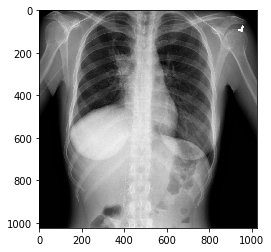

Predicted:  [[0.45940667]] No Lung Opacity/Not normal


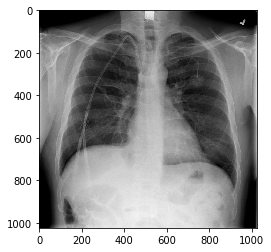

Predicted:  [[0.44282287]] No Lung Opacity/Not normal


In [41]:
import numpy as np

#load, resize and display test images
test_img_path1 = os.path.join(WRK_TEST_DIR, '0005d3cc-3c3f-40b9-93c3-46231c3eb813.png')
test_img_path2 = os.path.join(WRK_TEST_DIR, '0d6243f2-28a3-4b89-b461-de17dd77f1ca.png') #   #0000a175-0e68-4ca4-b1af-167204a7e0bc.png
img1 = load_img(test_img_path1, target_size=(img_width, img_height))
img2 = load_img(test_img_path2, target_size=(img_width, img_height))
plt.imshow(img1)
plt.show()

#convert image to numpy array, so that Keras can render a prediction
conv_img_arr = img_to_array(img1)

#expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch_size, height, width, channels)
x = np.expand_dims(conv_img_arr, axis=0) * 1./255

#get prediction on test image
score = model.predict(x)
print('Predicted: ',score, 'No Lung Opacity/Not normal' if score < 0.5 else 'With Lung Opacity')

#display and render prediction for the 2nd image
plt.imshow(img2)
plt.show()
conv_img2_arr = img_to_array(img2)
x1 = np.expand_dims(conv_img2_arr, axis=0) * 1./255
score2 = model.predict(x1)
print('Predicted: ',score2, 'No Lung Opacity/Not normal' if score2 < 0.5 else 'With Lung Opacity')
